# 基于YOLOV7-POSE的人体姿态估计和部署 

参考项目：https://github.com/trancongman276/yolov7-pose 

In [2]:
# Dataset utils and dataloaders

import cv2
import numpy as np


def letterbox(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)


In [3]:
import torch
import numpy as np


def xyxy2xywh(x):
    # Convert nx4 boxes from [x1, y1, x2, y2] to [x, y, w, h] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 0] = (x[:, 0] + x[:, 2]) / 2  # x center
    y[:, 1] = (x[:, 1] + x[:, 3]) / 2  # y center
    y[:, 2] = x[:, 2] - x[:, 0]  # width
    y[:, 3] = x[:, 3] - x[:, 1]  # height
    return y


In [4]:
import numpy as np
import cv2

def output_to_keypoint(output):
    # Convert model output to target format [batch_id, class_id, x, y, w, h, conf]
    targets = []
    for i, o in enumerate(output):
        kpts = o[:,6:]
        o = o[:,:6]
        for index, (*box, conf, cls) in enumerate(o):
            targets.append([i, cls, *list(*xyxy2xywh(np.array(box)[None])), conf, *list(kpts[index])])
    return np.array(targets)

def plot_skeleton_kpts(im, kpts, steps, orig_shape=None):
    #Plot the skeleton and keypointsfor coco datatset
    palette = np.array([[255, 128, 0], [255, 153, 51], [255, 178, 102],
                        [230, 230, 0], [255, 153, 255], [153, 204, 255],
                        [255, 102, 255], [255, 51, 255], [102, 178, 255],
                        [51, 153, 255], [255, 153, 153], [255, 102, 102],
                        [255, 51, 51], [153, 255, 153], [102, 255, 102],
                        [51, 255, 51], [0, 255, 0], [0, 0, 255], [255, 0, 0],
                        [255, 255, 255]])

    skeleton = [[16, 14], [14, 12], [17, 15], [15, 13], [12, 13], [6, 12],
                [7, 13], [6, 7], [6, 8], [7, 9], [8, 10], [9, 11], [2, 3],
                [1, 2], [1, 3], [2, 4], [3, 5], [4, 6], [5, 7]]

    pose_limb_color = palette[[9, 9, 9, 9, 7, 7, 7, 0, 0, 0, 0, 0, 16, 16, 16, 16, 16, 16, 16]]
    pose_kpt_color = palette[[16, 16, 16, 16, 16, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9]]
    radius = 5
    num_kpts = len(kpts) // steps

    for kid in range(num_kpts):
        r, g, b = pose_kpt_color[kid]
        x_coord, y_coord = kpts[steps * kid], kpts[steps * kid + 1]
        if not (x_coord % 640 == 0 or y_coord % 640 == 0):
            if steps == 3:
                conf = kpts[steps * kid + 2]
                if conf < 0.5:
                    continue
            cv2.circle(im, (int(x_coord), int(y_coord)), radius, (int(r), int(g), int(b)), -1)

    for sk_id, sk in enumerate(skeleton):
        r, g, b = pose_limb_color[sk_id]
        pos1 = (int(kpts[(sk[0]-1)*steps]), int(kpts[(sk[0]-1)*steps+1]))
        pos2 = (int(kpts[(sk[1]-1)*steps]), int(kpts[(sk[1]-1)*steps+1]))
        if steps == 3:
            conf1 = kpts[(sk[0]-1)*steps+2]
            conf2 = kpts[(sk[1]-1)*steps+2]
            if conf1<0.5 or conf2<0.5:
                continue
        if pos1[0]%640 == 0 or pos1[1]%640==0 or pos1[0]<0 or pos1[1]<0:
            continue
        if pos2[0] % 640 == 0 or pos2[1] % 640 == 0 or pos2[0]<0 or pos2[1]<0:
            continue
        cv2.line(im, pos1, pos2, (int(r), int(g), int(b)), thickness=2)


In [5]:
def preprocess(img):
    # Resize + Padding to size (960, 960, 3)
    img, r, d = letterbox(img, 960, stride=64, auto=False)
    # Reshape to size (1, 3, 960, 960)
    _img = img.transpose(2, 0, 1)[np.newaxis, :, :, :]
    # Normalize image
    _img = _img / 255.
    _img = _img.astype(np.float32)
    return {'resized': img, 'norm':_img}


def postprocess(img, ort_outs):
    # Get skeleton key-points
    output_kpt = output_to_keypoint(ort_outs)
    img_out = img.copy()
    # Draw skeleton to image
    for idx in range(output_kpt.shape[0]):
        plot_skeleton_kpts(img_out, output_kpt[idx, 7:].T, 3)
    return img_out


def predict(img):
    # PreProcess image
    meta = preprocess(img)
    # Predict
    ort_inputs = {model.get_inputs()[0].name: meta['norm']}
    ort_outs = model.run(['output'], ort_inputs)
    # PostProcess result
    img_out = postprocess(meta['resized'], ort_outs)
    return img_out


Init model
Input image
Predicting


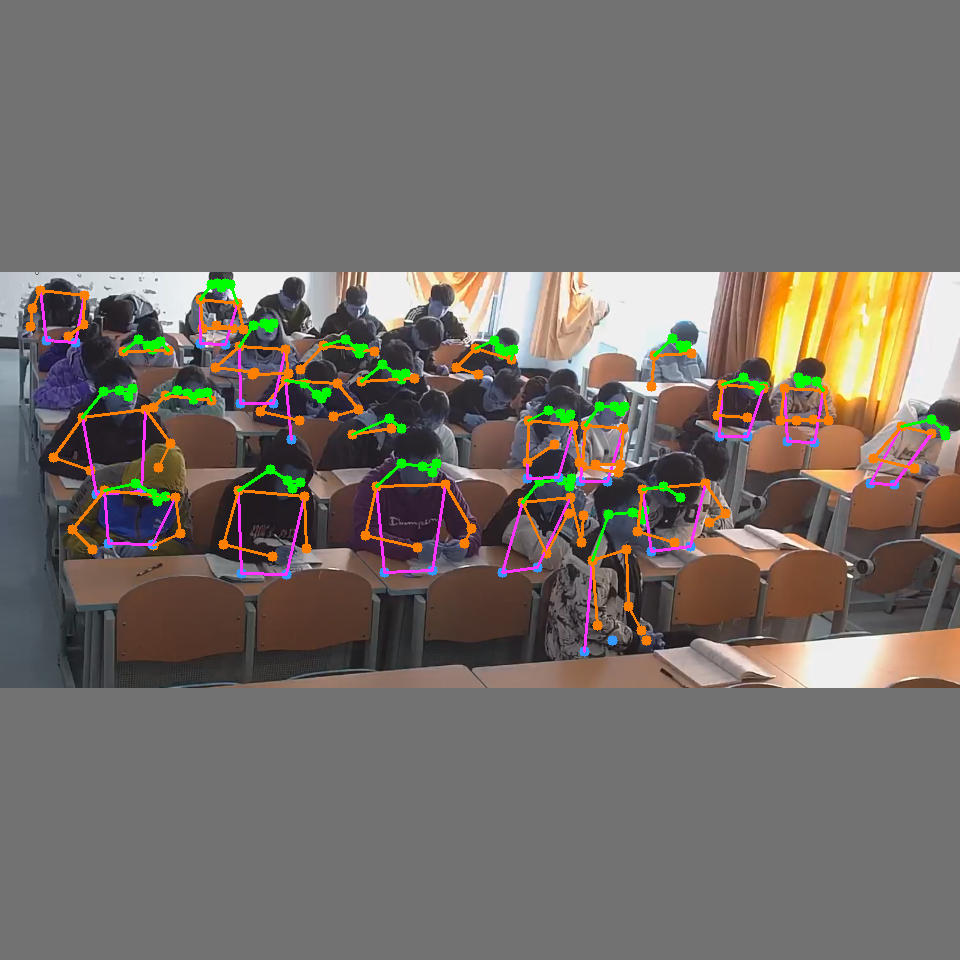

In [7]:
from PIL import Image 
import onnxruntime as ort 

# Init model
print('Init model')
model = ort.InferenceSession('./models/yolov7-w6-pose-nms.onnx')
# Input image
print('Input image')
img = cv2.imread("./images/student.png")
# Predict
print('Predicting')
img_out = predict(img)  
Image.fromarray(img_out)